# Assignment 3: Coding Part
**Course:** Machine Learning (DDA3020)

<font color=Red>*Please enter your personal information (double-click this cell to edit)*</font>  
**Name:**  CAI, Yuquan
**Student ID:** 122090007

## Overview

This is the **coding section** of Assignment 3. It includes **two main questions**:

- **Question 1:** K-Means Clustering
- **Question 2:** Gaussian Mixture Models (GMM)

Please follow the instructions in each cell. Complete the missing code in blocks marked with special comments such as:
```python
##########################
## Write your code here ##
##########################
```

Once completed, execute all cells and submit your final Jupyter notebook.

## Coding Question 1: K-Means Clustering

In this question, you will implement the **core logic of K-Means** from scratch and evaluate the results using the **Silhouette score**.

### 1.1 Data Preparation
We'll begin by generating a 2D synthetic dataset for clustering.

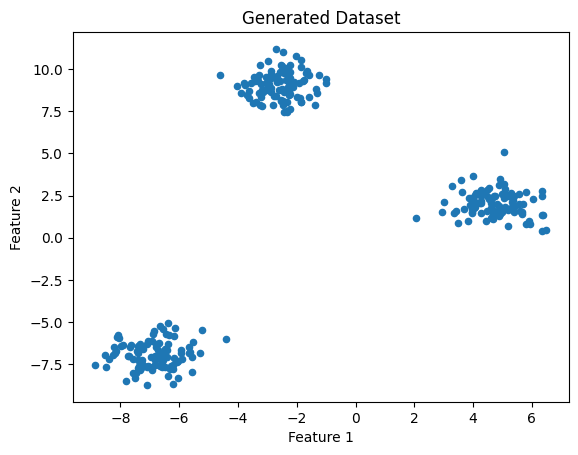

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate 2D synthetic data with 3 clusters
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.8, random_state=42)
plt.scatter(X[:, 0], X[:, 1], s=20)
plt.title("Generated Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### 1.2 K-Means Core Implementation

Complete the missing sections in the `KMeans` class to implement the core algorithm:
1. **Assigning clusters** <font color=blue>(8 points)</font>  
2. **Updating cluster centers** <font color=blue>(8 points)</font>  

The method `fit()` combines these steps iteratively.

In [91]:
class KMeans:
    def __init__(self, n_clusters=3, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        
    def initialize_centers(self, X):
        """Randomly select K data points as initial cluster centers"""
        np.random.seed(42)  # Reproducibility
        random_idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[random_idx]
    
    def assign_clusters(self, X, centers):
        """
        Assign each point to the nearest cluster center.

        Returns:
            labels : ndarray of shape (n_samples,)
        """
        distances = np.zeros((X.shape[0], self.n_clusters))

        ##########################
        ## Write your code here ##
        for i in range(self.n_clusters):
            distances[:, i] = np.sqrt(np.sum((X - centers[i]) ** 2, axis=1))

        label = np.argmin(distances, axis=1)
        return label
        ##########################


    def update_centers(self, X, labels):
        """
        Recalculate cluster centers as the mean of points in each cluster.

        Returns:
            new_centers : ndarray of shape (n_clusters, n_features)
        """
        new_centers = np.zeros((self.n_clusters, X.shape[1]))

        ##########################
        ## Write your code here ##
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centers[i] = cluster_points.mean(axis=0)
            else:
                random_point_idx = np.random.randint(X.shape[0])
                new_centers[i] = X[random_point_idx]
        return new_centers
        ##########################

    
    def fit(self, X):
        """Run the full K-means algorithm."""
        self.centers = self.initialize_centers(X)
        for _ in range(self.max_iter):
            labels = self.assign_clusters(X, self.centers)
            new_centers = self.update_centers(X, labels)
            if np.allclose(self.centers, new_centers):
                break
            self.centers = new_centers
        return self

### 1.3 Visualization of K-Means Result
Let's visualize the clusters and the final learned centers.

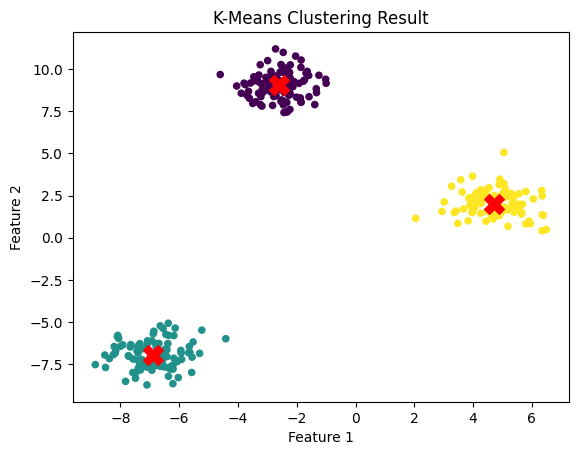

In [92]:
model = KMeans(n_clusters=3)
model.fit(X)
predicted_labels = model.assign_clusters(X, model.centers)

# Plot clustered points and centroids
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='viridis', s=20)
plt.scatter(model.centers[:, 0], model.centers[:, 1], c='red', s=200, marker='X')
plt.title("K-Means Clustering Result")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### 1.4 Silhouette Score Evaluation

Implement a function to compute the **Silhouette Score**, which measures how well samples are clustered.

- $a(i)$: average intra-cluster distance
- $b(i)$: average nearest-cluster distance

Final score is:
$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$
<font color=blue>(10 points)</font>  

In [93]:
def silhouette_score(X, labels):
    """
    Compute the mean Silhouette score.

    Parameters:
        X : ndarray of shape (n_samples, n_features)
        labels : ndarray of shape (n_samples,)

    Returns:
        float: Silhouette score in [-1, 1]
    """
    n_samples = X.shape[0]
    unique_labels = np.unique(labels)
    silhouette_vals = np.zeros(n_samples)
    
    for i in range(n_samples):
        cluster_id = labels[i]

        ##########################
        ## Write your code here ##
        intra_cluster_data = (labels == cluster_id)
        intra_cluster_data[i] = False
        ai = np.mean(np.linalg.norm(X[i] - X[intra_cluster_data], axis=1))


        bi = np.inf
        for cluster in unique_labels:
            if cluster != cluster_id:
                other_cluster = (labels == cluster)
                avg_dist = np.mean(np.linalg.norm(X[i] - X[other_cluster], axis=1))
                bi = min(bi, avg_dist)

        silhouette_vals[i] = (bi - ai) / max(ai, bi)

    return np.mean(silhouette_vals)
        ##########################



score = silhouette_score(X, predicted_labels)
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.878


## Coding Question 2: Gaussian Mixture Model (GMM)

In this question, you will implement a **Gaussian Mixture Model (GMM)** using the **Expectation-Maximization (EM)** algorithm.

A GMM is a probabilistic clustering model that assumes the data is generated from a mixture of $K$ Gaussian distributions:

$$
p(x) = \sum_{k=1}^K \pi_k \cdot \mathcal{N}(x \mid \mu_k, \Sigma_k)
$$

Where:
- $\pi_k$ is the mixing coefficient for the $k$-th Gaussian (with $\sum_k \pi_k = 1$)
- $\mu_k$, $\Sigma_k$ are the mean and covariance of the $k$-th Gaussian

You will:
- Implement the EM algorithm (E-step and M-step)
- Apply GMM to the same synthetic dataset as K-means
- Visualize the clustering result

### 2.1 Multivariate Gaussian Density

Before implementing GMM, we need a function to compute the multivariate Gaussian density:

$$
\mathcal{N}(x \mid \mu, \Sigma) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left( -\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu) \right)
$$

> 🛠️ **Task**: Complete the function $gaussian_pdf(x, mean, cov)$ to compute the density value at point $x$  
> The output should be a **scalar** representing $ p(x \mid \mu, \Sigma) $

<font color=blue>(8 points)</font>  

In [94]:
def gaussian_pdf(x, mean, cov):
    """
    Compute the multivariate normal density for a single sample x.

    Parameters:
        x    : (d,) array, input point
        mean : (d,) array, Gaussian mean
        cov  : (d, d) array, covariance matrix

    Returns:
        float: p(x | mean, cov)
    """
    d = x.shape[0]

    ##########################
    ## Write your code here ##
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    density = np.exp(-0.5 * (x - mean).T @ inv_cov @ (x - mean)) / np.sqrt((2 * np.pi) ** d * det_cov)
    return density
    ##########################
    

### 2.2 GMM Class & EM Algorithm

You will now complete the core GMM algorithm by filling in the missing parts in the `e_step()` and `m_step()` methods.

#### EM Steps Recap:

- **E-step**: Compute responsibility $\gamma_k^{(n)}$ for each data point <font color=blue>(8 points)</font>  :
$$
\gamma_k^{(n)} = \frac{\pi_k \cdot \mathcal{N}(x^{(n)} \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \cdot \mathcal{N}(x^{(n)} \mid \mu_j, \Sigma_j)}
$$

- **M-step**: Update model parameters based on current responsibilities <font color=blue>(8 points)</font>  :
$$
N_k = \sum_n \gamma_k^{(n)} \quad \quad
\mu_k = \frac{1}{N_k} \sum_n \gamma_k^{(n)} x^{(n)}
$$
$$
\Sigma_k = \frac{1}{N_k} \sum_n \gamma_k^{(n)} (x^{(n)} - \mu_k)(x^{(n)} - \mu_k)^T \quad \quad
\pi_k = \frac{N_k}{N}
$$


In [95]:
class GMM:
    def __init__(self, n_components=3, max_iter=100):
        self.K = n_components
        self.max_iter = max_iter
    
    def initialize_params(self, X):
        N, D = X.shape
        np.random.seed(42)
        idx = np.random.choice(N, self.K, replace=False)
        self.means = X[idx]
        self.covariances = np.array([np.eye(D)] * self.K)
        self.weights = np.ones(self.K) / self.K

    def e_step(self, X):
        """
        E-step: compute responsibility matrix gamma (N x K)
        return gamma
        """
        N = X.shape[0]
        gamma = np.zeros((N, self.K))

        ##########################
        ## Write your code here ##
        for i in range(N):
            total_p = 0
            for k in range(self.K):
                p = self.weights[k] * gaussian_pdf(X[i], self.means[k], self.covariances[k])
                gamma[i, k] = p
                total_p += p
            gamma[i] /= total_p

        return gamma
        ##########################
        

    def m_step(self, X, gamma):
        """
        M-step: update weights, means, and covariances
        """
        N, D = X.shape
        Nk = np.sum(gamma, axis=0)
        self.weights = Nk / N

        ##########################
        ## Write your code here ##
        self.means = np.zeros((self.K, D))
        self.covariances = np.zeros((self.K, D, D))

        for k in range(self.K):
            self.means[k] = np.sum(gamma[:, k][:, np.newaxis] * X, axis=0) / Nk[k]

            diff = X - self.means[k]
            weighted_diff = gamma[:, k][:, np.newaxis] * diff
            self.covariances[k] = (weighted_diff.T @ diff) / Nk[k]
        ##########################

        

    def fit(self, X):
        self.initialize_params(X)
        for _ in range(self.max_iter):
            gamma = self.e_step(X)
            self.m_step(X, gamma)
        return self

    def predict(self, X):
        gamma = self.e_step(X)
        return np.argmax(gamma, axis=1)

### 2.3 Visualize GMM Clustering Result

Now that your GMM is implemented, run it on the dataset and visualize the learned clusters.

> 🛠️ **Task 3**: Run your GMM on the same dataset and display the result

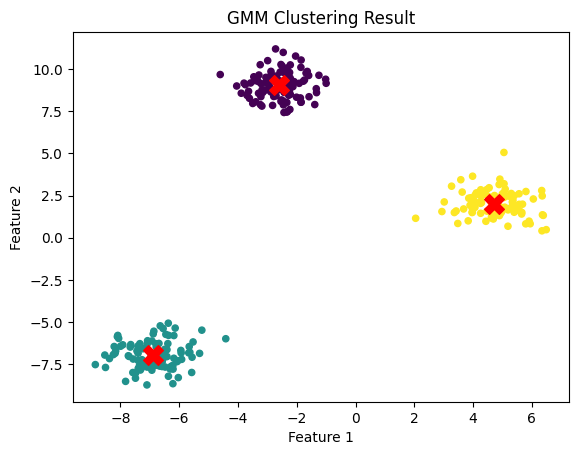

In [96]:
gmm = GMM(n_components=3)
gmm.fit(X)
gmm_labels = gmm.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis', s=20)
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', s=200, marker='X')
plt.title("GMM Clustering Result")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [97]:
print(f"KMeans Silhouette: {silhouette_score(X, predicted_labels):.3f}")
print(f"GMM    Silhouette: {silhouette_score(X, gmm_labels):.3f}")

KMeans Silhouette: 0.878
GMM    Silhouette: 0.878
